In [6]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv("/Users/colepuls/CS/MUHackathon2025/Raw_data/diabetes.csv")

# Count duplicate how many duplicate rows exist
num_dups = data.duplicated().sum()

# Remove any dups
if num_dups > 0:
    data.drop_duplicates(inplace=True)

# List columns where zeros are likely invalid or indicate missing data
cols_to_clean = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace 0 with nan, indicates missing value
for c in cols_to_clean:
    data[c].replace(0, np.nan, inplace=True)

# Impute missing values, fill with column means
data[cols_to_clean] = data[cols_to_clean].fillna(data[cols_to_clean].mean())

# Split targets
x = data.drop(columns=["Outcome"]).values
y = data["Outcome"].values

# Convert into tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long) # for classification labels

# Calculate mean and std for each feature (column)
mean = x_tensor.mean(dim=0)
std = x_tensor.std(dim=0)

std[std == 0] = 1e-7 # avoid division by zero

# Normalize!!!
x_tensor = (x_tensor - mean) / std # x tensor is now normalized column wise, mean of 0 and std of 1

class DiabetesDataset(Dataset): # store into dataset
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# initialize dataset    
dataset = DiabetesDataset(x_tensor, y_tensor)

# Split into training and validation sets

# 80/20 split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size # first test against unseen data

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders, DataLoader helps working with the data.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# neural network
class Network(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=2): # features (8), neurons (16), outputs (2) -> has diabetes (1), does not have diabetes (0)
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU() # Rectified linear unit, max(0,a) a is a neuron.
        self.dropout1 = nn.Dropout(p=0.3) # dropout layer, prevents overfitting (training data too closely) by randomly setting a fraction of neurons to zero during training.
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) # 2nd hidden layer added
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    
model = Network(input_dim=x.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005) # learning rate = 0.0005
    
# Training
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad() # reset gradients
        outputs = model(batch_features) # compute forward pass
        loss = criterion(outputs, batch_labels) # calculate loss
        loss.backward() # Backpropagation, compute gradient
        optimizer.step() # Minimize the loss, update parameters. Update the models weights using gradients
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

# Validation, bechmarking / testing
model.eval()                                                # Set model to evaluation mode
val_loss = 0                                        
correct = 0
total = 0
with torch.no_grad():
    for val_features, val_labels in val_loader:             # Loop through all batches of the validation data
        val_outputs = model(val_features)
        loss = criterion(val_outputs, val_labels)
        val_loss += loss.item()                             # Calculate loss
        _, predicted = torch.max(val_outputs, dim=1)        # Make predictions
        correct += (predicted == val_labels).sum().item()
        total += val_labels.size(0)                         # Track correct predictions and total samples
avg_val_loss = val_loss / len(val_loader)
accuracy = 100 * correct / total                            # Report metrics

/var/folders/43/2x89vvws2g56p_wbgrnwxvlm0000gn/T/ipykernel_5515/1654451217.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[c].replace(0, np.nan, inplace=True)


Data shape:  (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB
Data info:  None
Stats:
        Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.686763      72.40

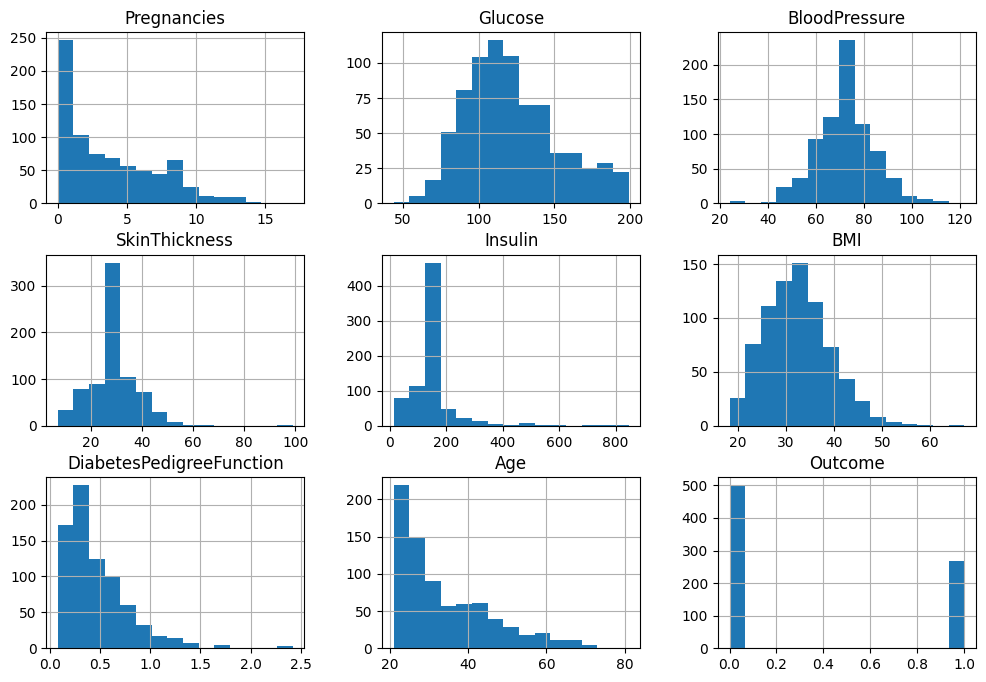

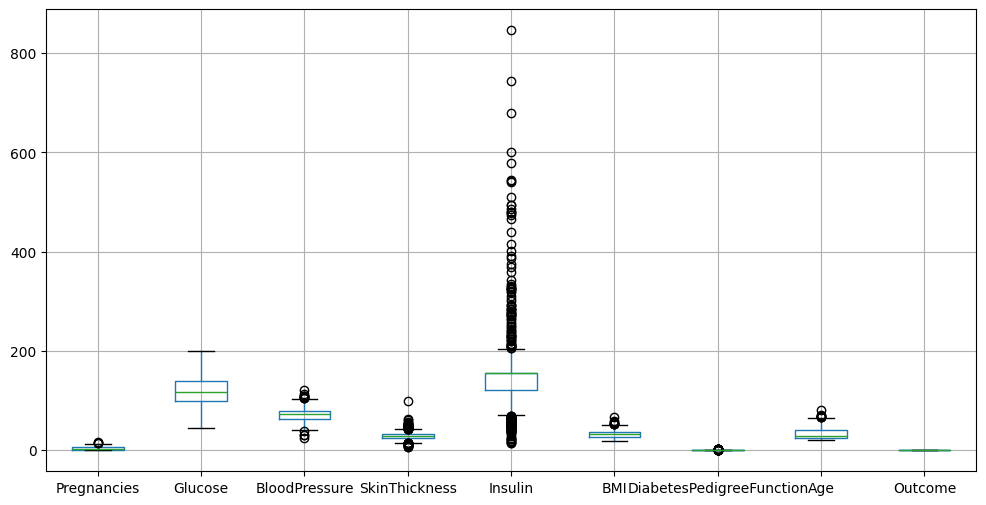

In [7]:
# visualize data
print("Data shape: ", data.shape)
print("Data info: ", data.info())
print("Stats:\n", data.describe())
print("Outcome distribution:\n", data["Outcome"].value_counts(normalize=True)*100)

data.hist(figsize=(12,8), bins=15)
plt.show()
data.boxplot(figsize=(12,6))
plt.show()

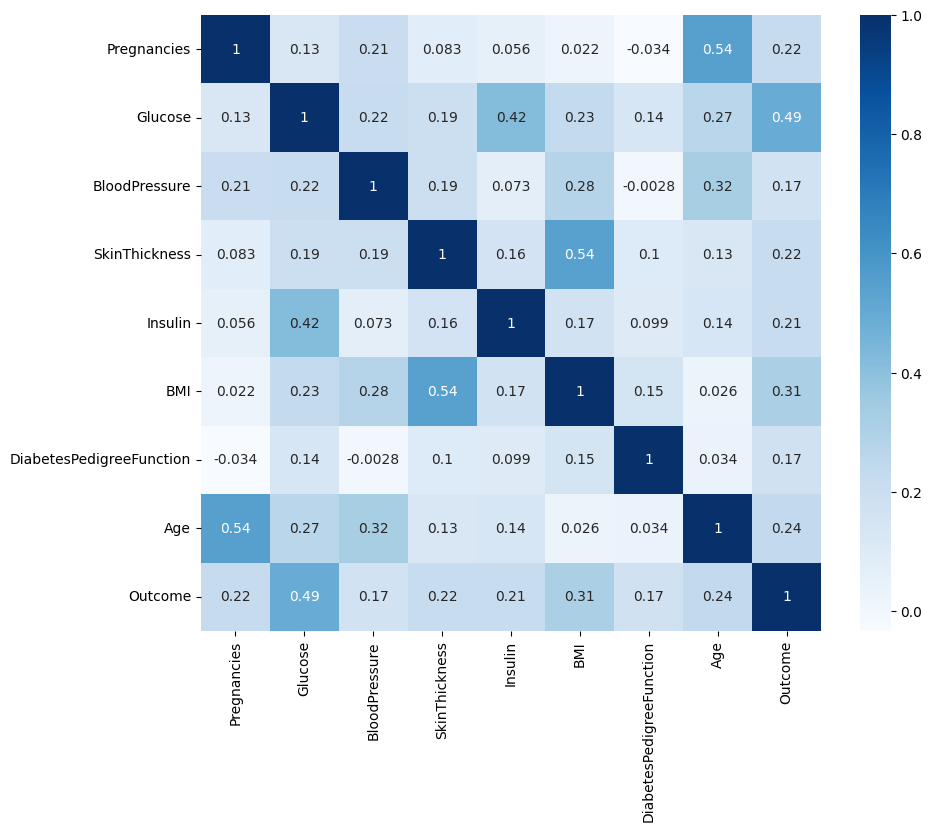

In [11]:
corr = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.show()
